In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
import statsmodels.stats.power as smp
from scipy import stats
from scipy.stats import norm, t, shapiro


In [2]:
def create_family_status(row):
    if row['marital.status'] == 'Married-civ-spouse':
        return 'Married-with-family' if row['relationship'] in ['Husband', 'Wife'] else 'Married-alone'
        
    if row['marital.status'] == 'Never-married':
        return 'Single-with-family' if row['relationship'] in ['Own-child', 'Other-relative'] else 'Single-alone'
        
    if row['marital.status'] == 'Divorced':
        return 'Separated-with-family' if row['relationship'] != 'Not-in-family' else 'Separated-alone'
        
    if row['marital.status'] == 'Widowed':
        return 'Separated-with-family' if row['relationship'] != 'Not-in-family' else 'Separated-alone'
        
    if row['marital.status'] == 'Separated':
        return 'Separated-with-family' if row['relationship'] != 'Not-in-family' else 'Separated-alone'
    
    return 'Not-in-Family'
def impute_mode(df, col_list):
    for col in col_list:
        df[col] = df[col].replace('?', np.nan)
        mode_value = df[col].mode()[0]
        df[col] = df[col].fillna(mode_value)



In [3]:
df_org = pd.read_csv(r"census_income_original_2.csv")
df = df_org.copy()

# preprocessiong
df = df_org.copy()

# encode income
df['income>50k'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)



# combine net gain and loss
df['capital.loss'] = df['capital.loss'] * -1
df['net_capital'] = df['capital.gain'] + df['capital.loss']
df['net_capital'] = df['net_capital'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# Clean
# Data inconsistency
df['income_value'] = pd.to_numeric(df['income_value'], errors='coerce')
df = df[~((df['occupation'] == 'Never worked') & (df['hours.per.week'] > 0))]
df = df[~((df['income>50k'] == 1) & (df['income_value'] <= 50000))]

# handlin income_value missing values (encode income value)
df['income_value_encoded'] = np.where(
    (df['income>50k'] == 1) & (df['income_value'] > 50000), 1,
        np.where((df['income>50k'] == 0) & (df['income_value'] <= 50000), 1, 0))




# handling missing catigorical variables
#impute_mode(df, ["occupation"])

#encode gender
mapping = {
    'm': 0,'m ': 0,'M': 0,'malee': 0,'male ': 0,'male': 0,'Male': 0,'Female': 1,'female': 1,'f': 1
}
df['Gender'] = df['Gender'].map(mapping)

# encode family 
df['family_status'] = df.apply(create_family_status, axis=1)

cat_cols = ['family_status', 'occupation']

# encode catigorical
#encoder = ce.BinaryEncoder(cols=cat_cols)
#df = encoder.fit_transform(df)

df = pd.get_dummies(df, columns=cat_cols)

# rescale
quantile_transformer = QuantileTransformer(output_distribution='uniform', random_state=42)
df[['age', 'hours.per.week']] = quantile_transformer.fit_transform(df[['age', 'hours.per.week']])

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['age', 'hours.per.week']])
df[['age', 'hours.per.week']] = df_scaled

scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled = scaler.fit_transform(df[['net_capital']])
df['net_capital'] = df_scaled



df.drop(columns=[ 'ID', 'capital.gain', 'capital.loss', 'education', 'race', 'native.country', 'workclass', 'income', 'income_value', 'marital.status', 'relationship'], inplace=True)


C:\Users\t-aelmiggabbar\AppData\Local\Temp\ipykernel_10204\1515744274.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_org = pd.read_csv(r"census_income_original_2.csv")


In [4]:
df.head(5)

,age,education.num,Gender,hours.per.week,income>50k,net_capital,income_value_encoded,family_status_Married-alone,family_status_Married-with-family,family_status_Not-in-Family,...,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,"occupation_Prof-,specialty",occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving
0,1.000000,9,1,0.469469,0,-1.0,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.997284,9,1,0.046547,0,-1.0,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.965465,10,1,0.469469,0,-1.0,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.855856,4,1,0.469469,0,-1.0,1,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,0.600601,10,1,0.469469,0,-1.0,1,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [5]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, average_precision_score
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

In [6]:

# Split data 
X = df.drop(columns=['income>50k'])
y = df['income>50k']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size (X_train):", X_train.shape)
print("Test set size (X_test):", X_test.shape)


Training set size (X_train): (26628, 29)
Test set size (X_test): (6657, 29)


In [7]:
def perform_grid_search(X_train, y_train, param_grid):
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)    
    print(f"Best parameters: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
    return best_model

param_grid = {
    'max_depth': [3, 6, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4]
}

#model = perform_grid_search(X_train, y_train, param_grid)

#Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators=300'}

In [8]:
def calculate_best_threshold(X_train, y_train):
    thresholds = np.linspace(0.3, 0.7, 10)
    model = RandomForestClassifier(random_state=42, max_depth=10, min_samples_split=3, min_samples_leaf=2, n_estimators=300)
    
    max_precision = -1
    best_threshold = 0.5
    best_recall = -1
    
    for t in thresholds:
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_train)[:, 1]
        y_pred_thresholded = (y_pred_proba >= t).astype(int)    
        conf_matrix = confusion_matrix(y_train, y_pred_thresholded)
        if conf_matrix.size == 0:
            continue
    
        TN, FP, FN, TP = conf_matrix.ravel()
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        
        if precision < recall and precision > max_precision:
            max_precision = precision
            best_threshold = t
            best_recall = recall
    
    if best_threshold is not None:
        print(f"Maximum Precision where Precision < Recall: {max_precision}")
        print(f"At Threshold: {best_threshold}")
        print(f"Recall: {best_recall}")
    return best_threshold
#calculate_best_threshold(X_train, y_train)

In [9]:
def CI_Eval(mean, var, n_folds, ci):
    std_dev = np.sqrt(var)
    z_score = t.ppf(1 - (1 - ci) / 2, n_folds-1) 
    margin_of_error = z_score * (std_dev / np.sqrt(n_folds))
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    print(f"{ci*100}% Confidence Interval: ({lower_bound:.4f}, {upper_bound:.4f})")

In [10]:

def bootstrap_ci(data, n_bootstraps=10000, ci_percentile=95):    
    bootstrap_means = np.zeros(n_bootstraps)
    for i in range(n_bootstraps):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)
    
    lower_percentile = np.percentile(bootstrap_means, (100 - ci_percentile) / 2)
    upper_percentile = np.percentile(bootstrap_means, 100 - (100 - ci_percentile) / 2)
    
    return lower_percentile, upper_percentile

In [11]:
l = []
def train_evaluate(model, X, y, threshold=0.5):
    X = X.values if isinstance(X, pd.DataFrame) else X
    y = y.values if isinstance(y, pd.Series) else y
    cv = StratifiedKFold(n_splits=45, shuffle=True, random_state=42)
    
    f1_scores = []
    all_conf_matrices = []

    fold_idx = 1
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        y_pred_thresholded = (y_pred_proba >= threshold).astype(int)
        conf_matrix = confusion_matrix(y_val, y_pred_thresholded)
        if conf_matrix.size == 0:
            continue
        
        TN, FP, FN, TP = conf_matrix.ravel()
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0 
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0  
        
        f1 = f1_score(y_val, y_pred_thresholded)
        f1_scores.append(f1)
        all_conf_matrices.append(conf_matrix)
        
        print(f"Fold {fold_idx}:")
        print(f"Threshold: {threshold}")
        print(f"FN**: {FN} | FP*: {FP} | TP: {TP} | TN: {TN}")
        print(f"Percison: {precision} | Recall: {recall}")
        print(f"F1 Score: {f1:.4f}")
        print("-" * 50)
        l.append(f1)
        fold_idx += 1

    print(f"Mean F1 Score across all folds: {np.mean(f1_scores):.4f}")
    print(f"Variance F1 Score across all folds: {np.var(f1_scores):.4f}")
    mean = np.mean(f1_scores)
    var = np.var(f1_scores)
    n_folds = 45
    ci = 0.95
    CI_Eval(mean, var, n_folds, ci)
    lower_ci, upper_ci = bootstrap_ci(f1_scores, n_bootstraps=10000, ci_percentile=95)
    print(f"95% Confidence Interval for F1 Scores bootstrap: ({lower_ci:.4f}, {upper_ci:.4f})")


In [12]:
model = RandomForestClassifier(random_state=42, max_depth=10, min_samples_split=3, min_samples_leaf=2, n_estimators=300)
threshold = 0.46
train_evaluate(model, X_train, y_train, threshold)


Fold 1:
Threshold: 0.46
FN**: 27 | FP*: 33 | TP: 121 | TN: 411
Percison: 0.7857142857142857 | Recall: 0.8175675675675675
F1 Score: 0.8013
--------------------------------------------------
Fold 2:
Threshold: 0.46
FN**: 28 | FP*: 32 | TP: 120 | TN: 412
Percison: 0.7894736842105263 | Recall: 0.8108108108108109
F1 Score: 0.8000
--------------------------------------------------
Fold 3:
Threshold: 0.46
FN**: 33 | FP*: 29 | TP: 115 | TN: 415
Percison: 0.7986111111111112 | Recall: 0.777027027027027
F1 Score: 0.7877
--------------------------------------------------
Fold 4:
Threshold: 0.46
FN**: 32 | FP*: 27 | TP: 116 | TN: 417
Percison: 0.8111888111888111 | Recall: 0.7837837837837838
F1 Score: 0.7973
--------------------------------------------------
Fold 5:
Threshold: 0.46
FN**: 27 | FP*: 27 | TP: 121 | TN: 417
Percison: 0.8175675675675675 | Recall: 0.8175675675675675
F1 Score: 0.8176
--------------------------------------------------
Fold 6:
Threshold: 0.46
FN**: 29 | FP*: 32 | TP: 119 | T

Shapiro-Wilk Test Statistic: 0.8865
P-value: 0.0004
reject h0: not normal


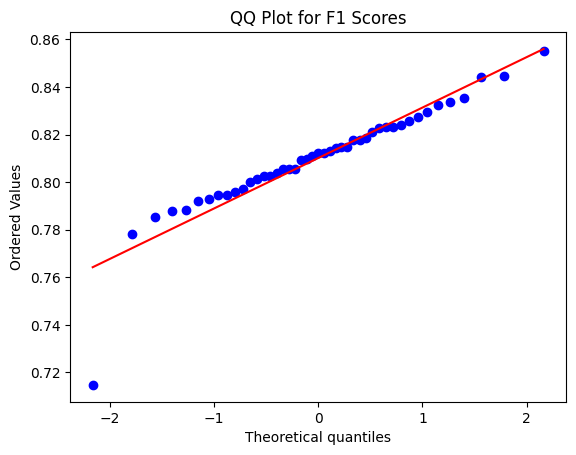

In [13]:
stat, p_value = shapiro(l)
print(f"Shapiro-Wilk Test Statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("reject h0: not normal")
else:
    print("fail to reject h0: normal")


stats.probplot(l, dist="norm", plot=plt)
# Display the plot
plt.title("QQ Plot for F1 Scores")
plt.show()


In [14]:
def test_model(model, X_test, y_test, threshold=0.5):
    X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
    y_test = y_test.values if isinstance(y_test, pd.Series) else y_test
        
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred_thresholded = (y_pred_proba >= threshold).astype(int)
    
    conf_matrix = confusion_matrix(y_test, y_pred_thresholded)
    TN, FP, FN, TP = conf_matrix.ravel()
    
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = f1_score(y_test, y_pred_thresholded)

    print(f"Test Set Evaluation:")
    print(f"Threshold: {threshold}")
    print(f"FN: {FN} | FP: {FP} | TP: {TP} | TN: {TN}")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 50)


In [15]:
threshold = 0.46
test_model(model, X_test, y_test, threshold)

Test Set Evaluation:
Threshold: 0.46
FN: 293 | FP: 367 | TP: 1373 | TN: 4624
Precision: 0.7891 | Recall: 0.8241
F1 Score: 0.8062
--------------------------------------------------


                                Feature  Importance  Normalized Importance
5                  income_value_encoded    0.315901               1.000000
7     family_status_Married-with-family    0.197000               0.623613
1                         education.num    0.121402               0.384303
4                           net_capital    0.097674               0.309192
0                                   age    0.076511               0.242200
3                        hours.per.week    0.042174               0.133504
17           occupation_Exec-managerial    0.024365               0.077127
12     family_status_Single-with-family    0.024308               0.076947
24            occupation_Prof-specialty    0.021756               0.068868
2                                Gender    0.019490               0.061697
11           family_status_Single-alone    0.017408               0.055107
10  family_status_Separated-with-family    0.009152               0.028970
21             occupation

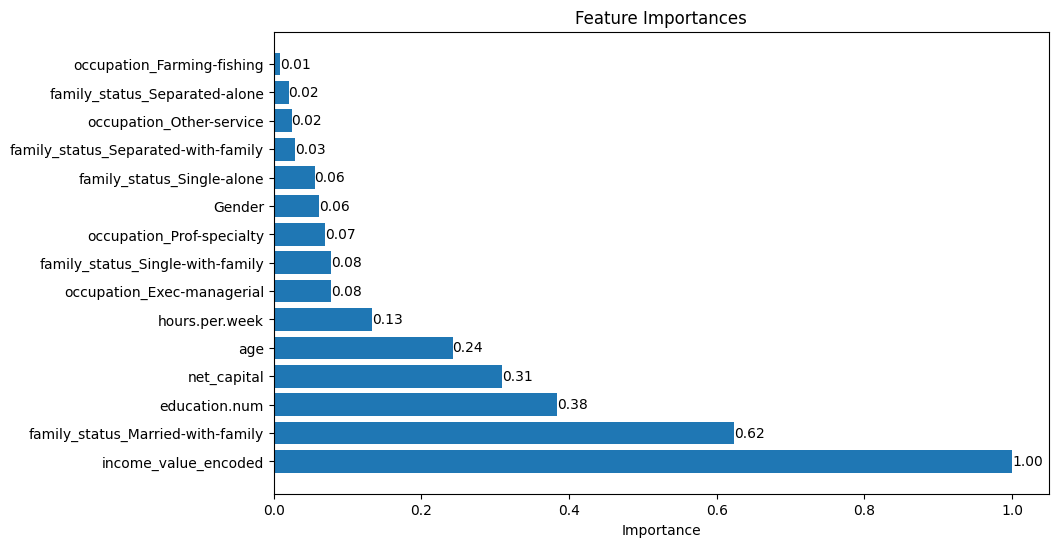

In [16]:
feature_importances = model.feature_importances_
feature_names = X_train.columns 
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df = feature_importance_df[:15]
total_importance = feature_importance_df['Importance'].max()
feature_importance_df['Normalized Importance'] = feature_importance_df['Importance'] / total_importance

print(feature_importance_df[:15])
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Normalized Importance'])
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}', 
             va='center', ha='left', fontsize=10, color='black')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()
